# Lattice Monte Carlo Simulation Example

This notebook demonstrates how to set up and run a Monte Carlo simulation on a 3D lattice of particles with quaternion orientations. We'll track order parameters, run the simulation, and visualize the results.

In [ ]:
# Import required libraries
import json
import pathlib
from decimal import Decimal
import numpy as np
import matplotlib.pyplot as plt

from latticemc import simulation_numba
from latticemc.definitions import DefiningParameters, Lattice, LatticeState, OrderParametersHistory
from latticemc.failsafe import failsafe_save_simulation
from latticemc.lattice_tools import initialize_partially_ordered
from latticemc.random_quaternion import random_quaternion
from latticemc.updaters import FluctuationsCalculator, OrderParametersCalculator, RandomWiggleRateAdjustor

In [ ]:
# Also import the new Simulation class for easier use and progress bars
from latticemc.simulation import Simulation
from latticemc.parallel import ProgressBarMode
from typing import List, cast
from latticemc.updaters import Updater

In [ ]:
# Create a 9x9x9 lattice of particles
lattice = Lattice(9, 9, 9)

# Initialize the lattice with partially ordered state
# This gives the system a non-random starting configuration
initialize_partially_ordered(lattice, x=random_quaternion(1))

# Define simulation parameters
# temperature: thermal energy scale (in units where kB = 1)
# lam: coupling strength parameter  
# tau: time step parameter
model_params = DefiningParameters(
    temperature=round(Decimal(0.9), 1),
    lam=round(Decimal(0.3), 1),
    tau=round(Decimal(1), 1)
)

# Create the simulation state
state = LatticeState(parameters=model_params, lattice=lattice)

# Initialize data collection for order parameters and fluctuations
order_parameters_history = OrderParametersHistory(lattice.size)

print(f"Created lattice: {lattice.X}×{lattice.Y}×{lattice.Z} = {lattice.X * lattice.Y * lattice.Z} particles")
print(f"Simulation parameters: T={model_params.temperature}, λ={model_params.lam}, τ={model_params.tau}")

Created lattice: 9×9×9 = 729 particles
Simulation parameters: T=0.9, λ=0.3, τ=1.0


In [3]:
# Set up data collection and system updaters
# Order parameters calculator: computes energy, orientational order parameters every step
order_parameters_calculator = OrderParametersCalculator(
    order_parameters_history, how_often=1, since_when=1, print_every=1000
)

# Fluctuations calculator: computes variance in order parameters over a sliding window  
fluctuations_calculator = FluctuationsCalculator(
    order_parameters_history, window=100, how_often=50, since_when=100, print_every=1000
)

# Set up system updaters for Monte Carlo dynamics
updaters = [
    order_parameters_calculator,    # Track order parameters
    fluctuations_calculator,        # Track fluctuations
    # Adjust wiggle rates to maintain good acceptance rates
    RandomWiggleRateAdjustor(scale=0.001, how_often=10, since_when=1),
    RandomWiggleRateAdjustor(scale=1.0, reset_value=1.0, how_often=1000, since_when=1000),
]

print("Set up simulation updaters:")
print("- Order parameters calculator (every step)")  
print("- Fluctuations calculator (every 50 steps, 100-step window)")
print("- Wiggle rate adjustors for good acceptance rates")

Set up simulation updaters:
- Order parameters calculator (every step)
- Fluctuations calculator (every 50 steps, 100-step window)
- Wiggle rate adjustors for good acceptance rates


In [4]:
# Run the Monte Carlo simulation
print(f"Starting Monte Carlo simulation at T={model_params.temperature}")

try:
    # Main simulation loop: 5,000 Monte Carlo steps (reduced for notebook)
    n_steps = 5000
    for step in range(n_steps):
        # Perform one Monte Carlo update step
        simulation_numba.do_lattice_state_update(state)

        # Apply all updaters (data collection, rate adjustments, etc.)
        for u in updaters:
            u.perform(state)
            
        # Print progress every 1000 steps
        if (step + 1) % 1000 == 0:
            current_energy = order_parameters_history.order_parameters['energy'][-1]
            print(f"Step {step + 1:5d}/{n_steps}: Energy = {current_energy:.4f}")

    print("\nSimulation completed successfully!")
    print(f"Final energy: {order_parameters_history.order_parameters['energy'][-1]:.4f}")
    print(f"Collected {len(order_parameters_history.order_parameters)} order parameter samples")

except Exception as e:
    print(f"Simulation failed with exception: {e}")
    # Save simulation state for debugging
    failsafe_save_simulation(e, state, order_parameters_history)

Starting Monte Carlo simulation at T=0.9
[1000,DefiningParameters(temperature=Decimal('0.9'), tau=Decimal('1.0'), lam=Decimal('0.3'))]:	 averg: energy=-4.85072,q0=0.89253,q2=0.29124,w=0.58472,p=0.71468,d322=0.75830
[1000,DefiningParameters(temperature=Decimal('0.9'), tau=Decimal('1.0'), lam=Decimal('0.3'))]:	 fluct: energy=0.44169,q0=0.01615,q2=0.02132,w=0.16396,p=0.06407,d322=0.01634
Step  1000/5000: Energy = -4.8507
[2000,DefiningParameters(temperature=Decimal('0.9'), tau=Decimal('1.0'), lam=Decimal('0.3'))]:	 averg: energy=-4.24489,q0=0.87884,q2=0.11072,w=0.93016,p=0.25377,d322=0.70006
[2000,DefiningParameters(temperature=Decimal('0.9'), tau=Decimal('1.0'), lam=Decimal('0.3'))]:	 fluct: energy=28.58988,q0=0.40463,q2=0.11612,w=0.47920,p=0.48555,d322=0.66447
Step  2000/5000: Energy = -4.2449
[3000,DefiningParameters(temperature=Decimal('0.9'), tau=Decimal('1.0'), lam=Decimal('0.3'))]:	 averg: energy=-4.20563,q0=0.90125,q2=0.12711,w=0.91295,p=0.30316,d322=0.76050
[3000,DefiningParamete

## Alternative: Using the Simulation Class

The above approach uses a manual simulation loop. For easier use, latticemc now provides a `Simulation` class that handles the loop automatically and includes progress bar support.

## Using the Simulation Class with Working Folders

The `Simulation` class provides a cleaner interface for running simulations with built-in progress bar support and automatic data saving. When you provide a `working_folder`, the simulation will automatically save:
- Order parameters and fluctuations history
- Simulation state for recovery
- JSON summaries with latest results
- Debug logs

Let's demonstrate this functionality:

In [ ]:
# Create a new state for the Simulation class demonstration
lattice2 = Lattice(9, 9, 9)
initialize_partially_ordered(lattice2, x=random_quaternion(1))

# Use the same parameters as before
state2 = LatticeState(parameters=model_params, lattice=lattice2)

# Set up working folder for automatic saving
working_folder = pathlib.Path("notebook_simulation_output")

# Additional updaters for this simulation
additional_updaters = [
    RandomWiggleRateAdjustor(scale=0.001, how_often=10, since_when=1),
    RandomWiggleRateAdjustor(scale=1.0, reset_value=1.0, how_often=1000, since_when=1000),
]

# Create simulation with working folder enabled
simulation = Simulation(
    initial_state=state2,
    cycles=3000,  # Number of Monte Carlo steps
    fluctuations_window=100,  # Window size for fluctuations calculation
    per_state_updaters=cast(List[Updater], additional_updaters),
    working_folder=working_folder,  # Enable automatic saving
    save_interval=500,  # Save every 500 steps
    auto_recover=True  # Attempt to recover from previous runs
)

### Progress Bar Modes

The simulation classes support three progress bar modes:

- `ProgressBarMode.NONE`: No progress bar (silent execution)
- `ProgressBarMode.CONSOLE`: Text-based progress bar for console environments
- `ProgressBarMode.NOTEBOOK`: Interactive progress bar optimized for Jupyter notebooks

You can switch between modes by changing the `progress_bar_mode` parameter when creating `Simulation` or `SimulationRunner` instances.

In [ ]:
# Run the simulation with working folder functionality
print("Running simulation with the Simulation class, progress bar, and automatic saving...")
print(f"Working folder: {working_folder}")
print(f"Save interval: every {simulation.save_interval} steps")

# This will show a progress bar in Jupyter notebooks
simulation.run()

print("Simulation class approach completed!")
print(f"Final energy: {simulation.local_history.order_parameters['energy'][-1]:.4f}")
print(f"Collected {len(simulation.local_history.order_parameters)} samples")
print(f"Data saved to: {working_folder.absolute()}")

# List the files that were created
if working_folder.exists():
    print("\nFiles created in working folder:")
    for file_path in sorted(working_folder.rglob("*")):
        if file_path.is_file():
            print(f"  {file_path.relative_to(working_folder)}")

## Results Visualization

Now let's plot the simulation results to visualize how the system evolved during the Monte Carlo simulation.

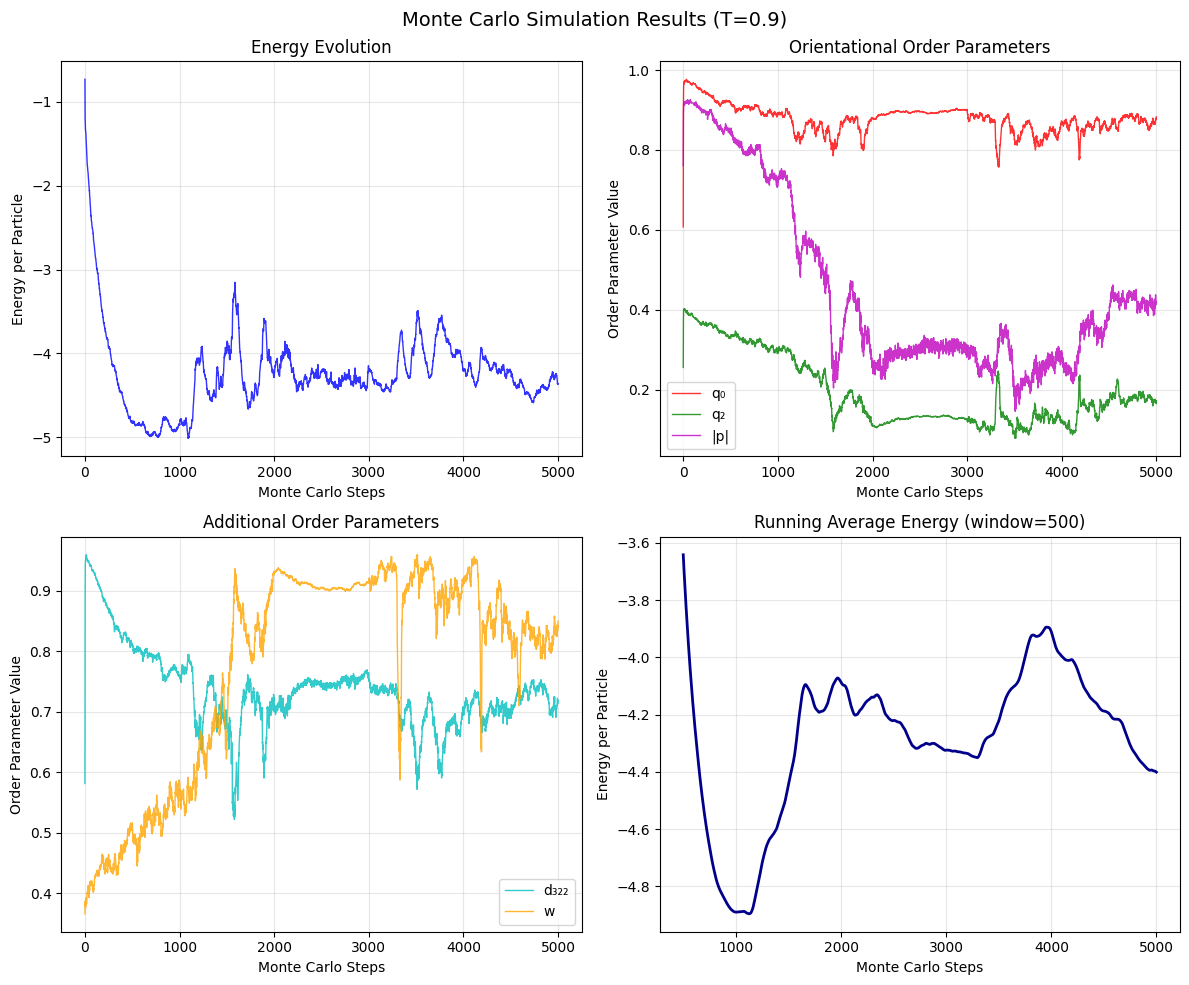


Final System Statistics:
  Energy per particle: -4.3679
  Order parameter q₀: 0.8826
  Order parameter q₂: 0.1654
  Nematic order |p|: 0.4156
  Total simulation steps: 5000


In [5]:
# Plot simulation results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'Monte Carlo Simulation Results (T={model_params.temperature})', fontsize=14)

# Get order parameters data
op = order_parameters_history.order_parameters
steps = np.arange(len(op))

# Plot 1: Energy evolution
axes[0,0].plot(steps, op['energy'], 'b-', linewidth=1, alpha=0.8)
axes[0,0].set_xlabel('Monte Carlo Steps')
axes[0,0].set_ylabel('Energy per Particle')
axes[0,0].set_title('Energy Evolution')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Order parameters
axes[0,1].plot(steps, op['q0'], 'r-', linewidth=1, alpha=0.8, label='q₀')
axes[0,1].plot(steps, op['q2'], 'g-', linewidth=1, alpha=0.8, label='q₂')
axes[0,1].plot(steps, np.abs(op['p']), 'm-', linewidth=1, alpha=0.8, label='|p|')
axes[0,1].set_xlabel('Monte Carlo Steps')
axes[0,1].set_ylabel('Order Parameter Value')
axes[0,1].set_title('Orientational Order Parameters')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Additional order parameters
axes[1,0].plot(steps, op['d322'], 'c-', linewidth=1, alpha=0.8, label='d₃₂₂')
axes[1,0].plot(steps, op['w'], 'orange', linewidth=1, alpha=0.8, label='w')
axes[1,0].set_xlabel('Monte Carlo Steps')
axes[1,0].set_ylabel('Order Parameter Value')
axes[1,0].set_title('Additional Order Parameters')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Running average of energy (last 500 points)
window = min(500, len(op) // 4)
if len(op) > window:
    running_avg = np.convolve(op['energy'], np.ones(window)/window, mode='valid')
    axes[1,1].plot(steps[window-1:], running_avg, 'darkblue', linewidth=2)
    axes[1,1].set_xlabel('Monte Carlo Steps')
    axes[1,1].set_ylabel('Energy per Particle')
    axes[1,1].set_title(f'Running Average Energy (window={window})')
    axes[1,1].grid(True, alpha=0.3)
else:
    axes[1,1].text(0.5, 0.5, 'Not enough data\nfor running average', 
                   ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Running Average Energy')

plt.tight_layout()
plt.show()

# Print final statistics
print(f"\nFinal System Statistics:")
print(f"  Energy per particle: {op['energy'][-1]:.4f}")
print(f"  Order parameter q₀: {op['q0'][-1]:.4f}")
print(f"  Order parameter q₂: {op['q2'][-1]:.4f}")
print(f"  Nematic order |p|: {abs(op['p'][-1]):.4f}")
print(f"  Total simulation steps: {len(op)}")

## Loading and Analyzing Saved Data

One of the key benefits of using working folders is that all simulation data is automatically saved and can be loaded later for analysis. Let's demonstrate how to load and analyze the saved data:

In [ ]:
# Load the JSON summary file
json_summary_path = working_folder / "summary.json"

if json_summary_path.exists():
    with open(json_summary_path, 'r') as f:
        summary = json.load(f)
    
    print("🔍 LOADED JSON SUMMARY")
    print(f"File: {json_summary_path}")
    print(f"Current step: {summary['current_step']}")
    print(f"Total cycles: {summary['total_cycles']}")
    print("Parameters:")
    for param, value in summary['parameters'].items():
        print(f"  {param}: {value}")
    
    print("\nLatest order parameters from file:")
    if 'latest_order_parameters' in summary:
        for param, value in summary['latest_order_parameters'].items():
            print(f"  {param}: {value:.6f}")
else:
    print("❌ JSON summary file not found")
    print(f"Expected at: {json_summary_path}")

In [ ]:
# Load the complete order parameters history from the NPZ file
order_params_path = working_folder / "data" / "order_parameters.npz"

if order_params_path.exists():
    loaded_data = np.load(order_params_path)
    
    print("📊 LOADED ORDER PARAMETERS HISTORY")
    print(f"File: {order_params_path}")
    print(f"Available arrays: {list(loaded_data.keys())}")
    
    if 'order_parameters' in loaded_data:
        loaded_order_params = loaded_data['order_parameters']
        print(f"Order parameters shape: {loaded_order_params.shape}")
        print(f"Total data points: {len(loaded_order_params)}")
        
        print("\nStatistics from loaded data:")
        print(f"  Energy range: {loaded_order_params['energy'].min():.4f} to {loaded_order_params['energy'].max():.4f}")
        print(f"  Mean energy: {loaded_order_params['energy'].mean():.4f} ± {loaded_order_params['energy'].std():.4f}")
        print(f"  Mean q0: {loaded_order_params['q0'].mean():.4f} ± {loaded_order_params['q0'].std():.4f}")
        print(f"  Mean q2: {loaded_order_params['q2'].mean():.4f} ± {loaded_order_params['q2'].std():.4f}")
        
        # Compare with in-memory data
        print(f"\n✅ Data consistency check:")
        print(f"  In-memory final energy: {simulation.local_history.order_parameters['energy'][-1]:.6f}")
        print(f"  Loaded final energy: {loaded_order_params['energy'][-1]:.6f}")
        print(f"  Match: {abs(simulation.local_history.order_parameters['energy'][-1] - loaded_order_params['energy'][-1]) < 1e-10}")
    
    # Check for fluctuations data
    fluctuations_path = working_folder / "data" / "fluctuations.npz"
    if fluctuations_path.exists():
        fluct_data = np.load(fluctuations_path)
        if 'fluctuations' in fluct_data:
            loaded_fluctuations = fluct_data['fluctuations']
            print(f"\nFluctuations shape: {loaded_fluctuations.shape}")
            print(f"Fluctuations data points: {len(loaded_fluctuations)}")
        
else:
    print("❌ Order parameters history file not found")
    print(f"Expected at: {order_params_path}")

In [ ]:
# Demonstrate loading and visualizing data from saved files
# This is particularly useful for post-processing analysis or resuming work later

if order_params_path.exists():
    # Create a comparison plot using both in-memory and loaded data
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    # Plot 1: Energy comparison
    ax1.plot(simulation.local_history.order_parameters['energy'], 'b-', alpha=0.7, label='In-memory')
    ax1.plot(loaded_order_params['energy'], 'r--', alpha=0.7, label='Loaded from file')
    ax1.set_xlabel('Monte Carlo Step')
    ax1.set_ylabel('Energy')
    ax1.set_title('Energy Evolution (Data Verification)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Q0 order parameter
    ax2.plot(loaded_order_params['q0'], 'g-', alpha=0.8)
    ax2.set_xlabel('Monte Carlo Step')
    ax2.set_ylabel('q₀ Order Parameter')
    ax2.set_title('Orientational Order (from saved data)')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Energy histogram from loaded data
    ax3.hist(loaded_order_params['energy'], bins=50, alpha=0.7, color='purple', edgecolor='black')
    ax3.set_xlabel('Energy')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Energy Distribution (from saved data)')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Order parameter correlation
    ax4.scatter(loaded_order_params['q0'], loaded_order_params['q2'], alpha=0.6, s=1, color='orange')
    ax4.set_xlabel('q₀ Order Parameter')
    ax4.set_ylabel('q₂ Order Parameter')
    ax4.set_title('Order Parameter Correlation (from saved data)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📈 Successfully created plots from loaded data!")
    print("This demonstrates how you can:")
    print("  • Load simulation data from disk")
    print("  • Verify data integrity")
    print("  • Create visualizations from saved results")
    print("  • Perform post-processing analysis")
else:
    print("❌ Cannot create comparison plots - data file not found")

## Recovery and Continuation Features

The working folder functionality also supports automatic recovery from interrupted simulations. Let's demonstrate this feature:

In [ ]:
# Demonstrate simulation recovery
# Create a new simulation with the same working folder
print("🔄 TESTING RECOVERY FUNCTIONALITY")

# Create a fresh lattice and state (simulating a restart scenario)  
recovery_lattice = Lattice(9, 9, 9)
initialize_partially_ordered(recovery_lattice, x=random_quaternion(1))
recovery_state = LatticeState(parameters=model_params, lattice=recovery_lattice)

# Create new simulation with same working folder and auto_recover=True
recovery_simulation = Simulation(
    initial_state=recovery_state,
    cycles=5000,  # More cycles to show continuation
    fluctuations_window=100,
    per_state_updaters=cast(List[Updater], additional_updaters),
    working_folder=working_folder,  # Same folder!
    save_interval=500,
    auto_recover=True  # This will attempt to recover from saved state
)

print(f"Original simulation completed {simulation.current_step} steps")
print(f"Recovery simulation will attempt to continue from where we left off...")
print(f"Target cycles: {recovery_simulation.cycles}")

# Check if recovery data exists
recovery_files_exist = (
    (working_folder / "simulation_state.dump").exists() and
    (working_folder / "order_parameters_history.npz").exists()
)

print(f"Recovery files exist: {recovery_files_exist}")

if recovery_files_exist:
    print("✅ Recovery should work - files are available")
    print("💡 In a real scenario, you could now run recovery_simulation.run()")
    print("   This would continue from the saved state instead of starting over")
else:
    print("❌ Recovery files not found - would start fresh simulation")

## Next Steps

This example demonstrates:
- Setting up a 3D lattice Monte Carlo simulation
- Configuring simulation parameters and updaters  
- Using **working folders** for automatic data saving and recovery
- Running simulations with progress bars
- Loading and analyzing saved simulation data
- Visualizing results from both in-memory and saved data

### Working Folder Benefits:
- **Automatic Saving**: Order parameters, fluctuations, and simulation state saved periodically
- **Recovery Support**: Resume interrupted simulations from saved checkpoints
- **Data Persistence**: All results available for later analysis
- **JSON Summaries**: Human-readable summaries of simulation progress
- **Debug Logs**: Detailed logging for troubleshooting

### For more advanced simulations, you can:

1. **Parallel Tempering**: Run multiple replicas at different temperatures simultaneously to improve sampling
2. **Longer Simulations**: Increase the number of Monte Carlo steps for better statistics
3. **Parameter Studies**: Vary temperature, coupling strength, or other parameters
4. **Different Initial Conditions**: Try random initialization or other ordered states
5. **Analysis**: Compute specific heat, susceptibilities, and phase transition points
6. **Data Processing**: Load saved data in separate notebooks for detailed analysis

### Key Files Created in Working Folder:
- `simulation_summary.json`: Latest simulation state and parameters
- `order_parameters_history.npz`: Complete time series data
- `simulation_state.dump`: Full simulation state for recovery
- `lattice_state.npz`: Current lattice configuration
- `logs/simulation.log`: Detailed debug information

### Key Order Parameters:
- **Energy**: Total system energy per particle
- **q₀, q₂**: Orientational order parameters for liquid crystal phases  
- **p**: Chirality
- **d₃₂₂, w**: Additional structural order parameters